In [4]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [5]:
# データの読み込み
data = pd.read_excel('data.xlsx', header = 1)

# 特徴量とターゲットの分離
X = data[['Concentration', 'time']]
y_Fe = data['Fe']
y_Al = data['Al']
y_Mn = data['Mn']

In [11]:
# 目的関数の定義 (MLR 用)
def objective_mlr(trial):
    # MLR モデルの定義
    model = LinearRegression()

    # 試行による最適化パラメータ
    X_train = pd.DataFrame({
        'Concentration': [trial.suggest_float('Concentration', 1.0, 3.0)],
        'time': [trial.suggest_float('time', 2.0, 60.0)]
    })
    
    # モデルのトレーニング
    model.fit(X, y_Fe)

    # 予測
    y_pred_Fe = model.predict(X_train)
    y_pred_Al = model.predict(X_train)
    y_pred_Mn = model.predict(X_train)

    # 目的関数の計算（Fe の最大化、Al の最小化、Mn の安定化）
    return -((y_pred_Fe[0] - y_pred_Al[0]) - abs(y_pred_Mn[0] - 5.3))

In [12]:
# Optunaによる最適化 (MLR)
study_mlr = optuna.create_study(direction='minimize', sampler=TPESampler())
study_mlr.optimize(objective_mlr, n_trials=500)

# 最適解の表示
print(f"MLR 最適解: {study_mlr.best_params}")

[I 2024-08-10 16:12:55,894] A new study created in memory with name: no-name-fe6194bd-7808-4b24-b8ef-1eb253015a09
[I 2024-08-10 16:12:55,901] Trial 0 finished with value: 5.180260411399447 and parameters: {'Concentration': 2.293418459031999, 'time': 4.225235911079378}. Best is trial 0 with value: 5.180260411399447.
[I 2024-08-10 16:12:55,907] Trial 1 finished with value: 5.174486355690855 and parameters: {'Concentration': 1.4010875548369497, 'time': 29.031665011987155}. Best is trial 1 with value: 5.174486355690855.
[I 2024-08-10 16:12:55,912] Trial 2 finished with value: 5.133588677647237 and parameters: {'Concentration': 1.419291571221899, 'time': 55.42466483351103}. Best is trial 2 with value: 5.133588677647237.
[I 2024-08-10 16:12:55,912] Trial 3 finished with value: 5.162356513876565 and parameters: {'Concentration': 2.5938041401548277, 'time': 8.891248529475291}. Best is trial 2 with value: 5.133588677647237.
[I 2024-08-10 16:12:55,924] Trial 4 finished with value: 5.134529255742

MLR 最適解: {'Concentration': 2.999471672848508, 'time': 59.994921389388594}


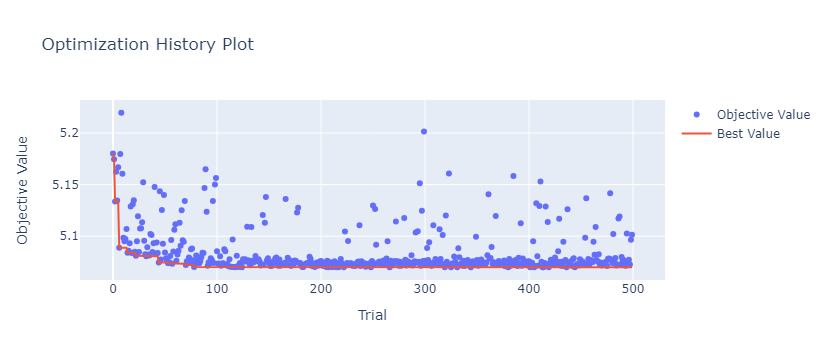

In [22]:
# 結果のプロット (オプション)
optuna.visualization.plot_optimization_history(study_mlr).show()

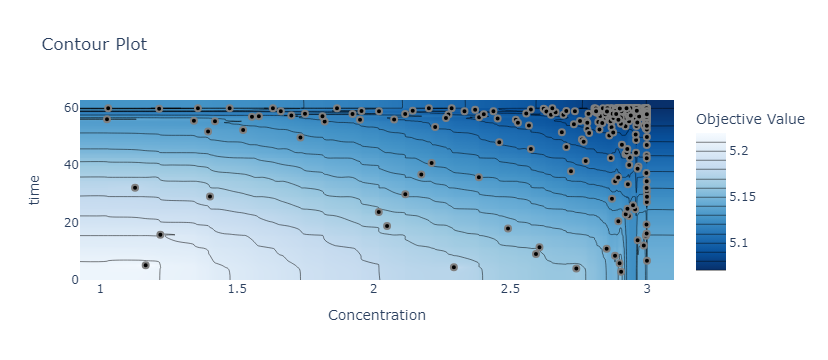

In [23]:
# 結果のプロット (オプション)
optuna.visualization.plot_contour(study_mlr).show()

In [25]:
# 目的関数の定義 (ANN 用)
def objective_ann(trial):
    # ANN モデルの定義
    model = Sequential()
    model.add(Dense(16, input_dim=2, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    # 最適化アルゴリズムと損失関数
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # 試行による最適化パラメータ
    X_train = np.array([[trial.suggest_float('Concentration', 1.0, 3.0),
                         trial.suggest_float('time', 2.0, 60.0)]])
    
    # モデルのトレーニング
    model.fit(X, y_Fe, epochs=10, verbose=0)

    # 予測
    y_pred_Fe = model.predict(X_train)
    y_pred_Al = model.predict(X_train)
    y_pred_Mn = model.predict(X_train)

    # 目的関数の計算（Fe の最大化、Al の最小化、Mn の安定化）
    return -((y_pred_Fe[0][0] - y_pred_Al[0][0]) - abs(y_pred_Mn[0][0] - 5.3))

In [27]:
# Optunaによる最適化 (ANN)
study_ann = optuna.create_study(direction='minimize', sampler=TPESampler())
study_ann.optimize(objective_ann, n_trials=100)

[I 2024-08-10 16:29:18,853] A new study created in memory with name: no-name-059b9309-7f86-43a2-a54a-6ae15473e077


1/1 [==============================] - 0s 24ms/step


[I 2024-08-10 16:29:19,772] Trial 0 finished with value: 5.2417949989438055 and parameters: {'Concentration': 1.2951127731458938, 'time': 22.829375241045977}. Best is trial 0 with value: 5.2417949989438055.


1/1 [==============================] - 0s 20ms/step


[I 2024-08-10 16:29:20,634] Trial 1 finished with value: 5.415627035498619 and parameters: {'Concentration': 1.9260814702168323, 'time': 6.531028123093872}. Best is trial 0 with value: 5.2417949989438055.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:29:21,460] Trial 2 finished with value: 5.072331446409225 and parameters: {'Concentration': 1.2620496090046174, 'time': 10.742297324718395}. Best is trial 2 with value: 5.072331446409225.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:29:22,595] Trial 3 finished with value: 5.058510500192642 and parameters: {'Concentration': 1.8078481060817575, 'time': 46.60079839975083}. Best is trial 3 with value: 5.058510500192642.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:29:23,495] Trial 4 finished with value: 5.113293918967247 and parameters: {'Concentration': 1.0758443709205399, 'time': 26.310306333105554}. Best is trial 3 with value: 5.058510500192642.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:29:24,380] Trial 5 finished with value: 5.134603667259216 and parameters: {'Concentration': 1.4412719299487065, 'time': 3.0820044176760475}. Best is trial 3 with value: 5.058510500192642.


1/1 [==============================] - 0s 28ms/step


[I 2024-08-10 16:29:25,232] Trial 6 finished with value: 5.390186350047588 and parameters: {'Concentration': 2.137208359957893, 'time': 17.68020267898234}. Best is trial 3 with value: 5.058510500192642.


1/1 [==============================] - 0s 20ms/step


[I 2024-08-10 16:29:26,084] Trial 7 finished with value: 5.186013373732567 and parameters: {'Concentration': 1.3999268187420888, 'time': 38.938278157896185}. Best is trial 3 with value: 5.058510500192642.


1/1 [==============================] - 0s 17ms/step


[I 2024-08-10 16:29:26,920] Trial 8 finished with value: 5.2131376445293425 and parameters: {'Concentration': 2.884466183556039, 'time': 50.48923518790762}. Best is trial 3 with value: 5.058510500192642.


1/1 [==============================] - 0s 20ms/step


[I 2024-08-10 16:29:27,780] Trial 9 finished with value: 5.049966442584991 and parameters: {'Concentration': 1.1111850473837506, 'time': 30.52763139327127}. Best is trial 9 with value: 5.049966442584991.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:28,588] Trial 10 finished with value: 5.039002585411072 and parameters: {'Concentration': 2.5742187883559713, 'time': 35.482749367737846}. Best is trial 10 with value: 5.039002585411072.


1/1 [==============================] - 0s 20ms/step


[I 2024-08-10 16:29:29,440] Trial 11 finished with value: 5.215647178888321 and parameters: {'Concentration': 2.643064585964857, 'time': 35.60597182680142}. Best is trial 10 with value: 5.039002585411072.


1/1 [==============================] - 0s 26ms/step


[I 2024-08-10 16:29:30,224] Trial 12 finished with value: 5.076050344109535 and parameters: {'Concentration': 2.46223944946151, 'time': 33.56598302856183}. Best is trial 10 with value: 5.039002585411072.


1/1 [==============================] - 0s 24ms/step


[I 2024-08-10 16:29:31,056] Trial 13 finished with value: 5.214653912186622 and parameters: {'Concentration': 2.3201293539420806, 'time': 58.21184433941063}. Best is trial 10 with value: 5.039002585411072.


1/1 [==============================] - 0s 15ms/step


[I 2024-08-10 16:29:31,826] Trial 14 finished with value: 4.298909711837768 and parameters: {'Concentration': 2.938332506028113, 'time': 44.0692340931441}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:29:32,634] Trial 15 finished with value: 4.795125412940979 and parameters: {'Concentration': 2.9887453769592733, 'time': 44.55145100081775}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:29:33,391] Trial 16 finished with value: 4.923368501663208 and parameters: {'Concentration': 2.991789480576057, 'time': 48.693333773234876}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 24ms/step


[I 2024-08-10 16:29:34,218] Trial 17 finished with value: 4.791914331912994 and parameters: {'Concentration': 2.7444141671655884, 'time': 42.71080552294532}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:34,983] Trial 18 finished with value: 5.246827411651611 and parameters: {'Concentration': 2.7738559745351714, 'time': 57.83264446099252}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:29:36,043] Trial 19 finished with value: 5.104790437221527 and parameters: {'Concentration': 2.2937954308221657, 'time': 39.79051698844375}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:29:36,814] Trial 20 finished with value: 5.272046015784144 and parameters: {'Concentration': 2.7208149299603246, 'time': 51.080296531625834}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:29:37,584] Trial 21 finished with value: 5.48505397439003 and parameters: {'Concentration': 2.99824893559384, 'time': 43.64128967121762}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 17ms/step


[I 2024-08-10 16:29:38,419] Trial 22 finished with value: 5.059959489107132 and parameters: {'Concentration': 2.8258829979102864, 'time': 43.87922563256017}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 20ms/step


[I 2024-08-10 16:29:39,171] Trial 23 finished with value: 5.4597986221313475 and parameters: {'Concentration': 2.4992437627859614, 'time': 52.813439057052975}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 23ms/step


[I 2024-08-10 16:29:39,961] Trial 24 finished with value: 4.715322124958038 and parameters: {'Concentration': 1.653876882193377, 'time': 42.20725361971779}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 22ms/step


[I 2024-08-10 16:29:40,707] Trial 25 finished with value: 5.20761461853981 and parameters: {'Concentration': 1.658270329274858, 'time': 40.575766875342424}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 17ms/step


[I 2024-08-10 16:29:41,465] Trial 26 finished with value: 5.078182491660118 and parameters: {'Concentration': 1.651604945168333, 'time': 29.352933234646883}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:29:42,253] Trial 27 finished with value: 5.423241081833839 and parameters: {'Concentration': 2.0622864345982825, 'time': 54.81632344025584}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:42,989] Trial 28 finished with value: 5.112244191765785 and parameters: {'Concentration': 2.324203690842991, 'time': 40.69467610371266}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:43,738] Trial 29 finished with value: 4.926201808452606 and parameters: {'Concentration': 1.7877476092005784, 'time': 22.871098483730684}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:29:44,502] Trial 30 finished with value: 5.128788354992866 and parameters: {'Concentration': 1.5732327052297164, 'time': 46.12980303297946}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 27ms/step


[I 2024-08-10 16:29:45,256] Trial 31 finished with value: 4.8897717773914335 and parameters: {'Concentration': 2.9115588538454062, 'time': 43.34599451997111}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 15ms/step


[I 2024-08-10 16:29:45,992] Trial 32 finished with value: 4.8725711584091185 and parameters: {'Concentration': 2.7071683818425223, 'time': 37.09239548411816}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 24ms/step


[I 2024-08-10 16:29:46,719] Trial 33 finished with value: 4.974390912055969 and parameters: {'Concentration': 2.8298705970937865, 'time': 54.79867685534103}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:29:47,447] Trial 34 finished with value: 5.22110837996006 and parameters: {'Concentration': 1.913823374140251, 'time': 48.33033330528145}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:29:48,180] Trial 35 finished with value: 5.792583811283111 and parameters: {'Concentration': 2.578080808743852, 'time': 45.16348548396462}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:29:49,223] Trial 36 finished with value: 5.214553798735142 and parameters: {'Concentration': 2.9207881613451394, 'time': 16.24628039140891}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 14ms/step


[I 2024-08-10 16:29:49,964] Trial 37 finished with value: 4.938098478317261 and parameters: {'Concentration': 1.2969064116181277, 'time': 34.129990471196415}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:50,733] Trial 38 finished with value: 5.5165834605693815 and parameters: {'Concentration': 2.1929475532310865, 'time': 27.931573252954422}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 15ms/step


[I 2024-08-10 16:29:51,470] Trial 39 finished with value: 5.629738467931747 and parameters: {'Concentration': 1.929026872612851, 'time': 32.40900695764567}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:29:52,226] Trial 40 finished with value: 5.1777997121214865 and parameters: {'Concentration': 2.4298491952480905, 'time': 41.925698954203256}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:53,073] Trial 41 finished with value: 5.1508720248937605 and parameters: {'Concentration': 2.713656511460557, 'time': 37.357824475764524}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 25ms/step


[I 2024-08-10 16:29:53,829] Trial 42 finished with value: 4.999063301086426 and parameters: {'Concentration': 2.6750413887412487, 'time': 37.95539848126519}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 24ms/step


[I 2024-08-10 16:29:54,658] Trial 43 finished with value: 5.304858836531639 and parameters: {'Concentration': 2.782960344552625, 'time': 47.37078589396769}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 20ms/step


[I 2024-08-10 16:29:55,385] Trial 44 finished with value: 4.795154619216919 and parameters: {'Concentration': 2.591913898180926, 'time': 45.244280995729184}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 23ms/step


[I 2024-08-10 16:29:56,106] Trial 45 finished with value: 5.008570599555969 and parameters: {'Concentration': 2.587042535917275, 'time': 50.45869863120384}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:56,839] Trial 46 finished with value: 4.766915547847748 and parameters: {'Concentration': 2.9075302751669603, 'time': 45.59087323473164}. Best is trial 14 with value: 4.298909711837768.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:29:57,693] Trial 47 finished with value: 4.1078629970550535 and parameters: {'Concentration': 2.9152153286837392, 'time': 54.015880432469295}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 11ms/step


[I 2024-08-10 16:29:58,523] Trial 48 finished with value: 5.37971428334713 and parameters: {'Concentration': 2.8760053174453453, 'time': 55.53810667420769}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 31ms/step


[I 2024-08-10 16:29:59,487] Trial 49 finished with value: 4.4641931533813475 and parameters: {'Concentration': 1.4569977660288433, 'time': 52.41214285403297}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:00,367] Trial 50 finished with value: 5.156478348374367 and parameters: {'Concentration': 1.4546788860973079, 'time': 52.140010000536314}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:01,124] Trial 51 finished with value: 5.178237441182136 and parameters: {'Concentration': 1.1953719411280719, 'time': 59.626815149859354}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:30:02,228] Trial 52 finished with value: 5.147211956977844 and parameters: {'Concentration': 1.484689006715191, 'time': 49.45534955558788}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 26ms/step


[I 2024-08-10 16:30:03,051] Trial 53 finished with value: 5.229753601551056 and parameters: {'Concentration': 1.3457977774371985, 'time': 53.22255215689394}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:30:03,829] Trial 54 finished with value: 5.072044971585274 and parameters: {'Concentration': 1.7915025576532022, 'time': 47.315745459774654}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 9ms/step


[I 2024-08-10 16:30:04,595] Trial 55 finished with value: 5.213766041398048 and parameters: {'Concentration': 2.9279409287093654, 'time': 41.872978325460984}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 23ms/step


[I 2024-08-10 16:30:05,379] Trial 56 finished with value: 5.21064241528511 and parameters: {'Concentration': 1.5768465799594802, 'time': 56.25161749026998}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 25ms/step


[I 2024-08-10 16:30:06,157] Trial 57 finished with value: 5.349048360437155 and parameters: {'Concentration': 2.8274101784736807, 'time': 5.020673024785971}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:30:07,148] Trial 58 finished with value: 5.351445335149765 and parameters: {'Concentration': 1.2096216122911962, 'time': 49.98064201052476}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:30:08,123] Trial 59 finished with value: 4.874366360902786 and parameters: {'Concentration': 1.020385816548676, 'time': 51.944153809735774}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 23ms/step


[I 2024-08-10 16:30:08,903] Trial 60 finished with value: 6.487025427818298 and parameters: {'Concentration': 1.7243521459557356, 'time': 56.96788590910486}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 17ms/step


[I 2024-08-10 16:30:09,639] Trial 61 finished with value: 5.046699959039688 and parameters: {'Concentration': 2.9494716844970235, 'time': 43.922436880712}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:10,345] Trial 62 finished with value: 5.1976098895072935 and parameters: {'Concentration': 2.9912697401080233, 'time': 46.12867076584784}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:30:11,051] Trial 63 finished with value: 4.9338110268115996 and parameters: {'Concentration': 2.845789134251678, 'time': 40.062431484700916}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:11,788] Trial 64 finished with value: 5.125953736901283 and parameters: {'Concentration': 2.78082917005424, 'time': 53.715630762536094}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 14ms/step


[I 2024-08-10 16:30:12,486] Trial 65 finished with value: 5.6146243691444395 and parameters: {'Concentration': 2.756539029936218, 'time': 41.62584773050918}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 23ms/step


[I 2024-08-10 16:30:13,199] Trial 66 finished with value: 4.751034724712372 and parameters: {'Concentration': 2.967520483338293, 'time': 48.17756870982485}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:13,904] Trial 67 finished with value: 5.126919540762901 and parameters: {'Concentration': 2.8817285995148323, 'time': 48.197700840083456}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:14,903] Trial 68 finished with value: 4.849750328063965 and parameters: {'Concentration': 2.506755856125665, 'time': 59.175986331090336}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 25ms/step


[I 2024-08-10 16:30:15,665] Trial 69 finished with value: 4.283892560005188 and parameters: {'Concentration': 2.646734442207647, 'time': 11.891529700088476}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 24ms/step


[I 2024-08-10 16:30:16,397] Trial 70 finished with value: 4.416102933883667 and parameters: {'Concentration': 2.6388799751181686, 'time': 15.721258736195255}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:17,119] Trial 71 finished with value: 4.860391694307327 and parameters: {'Concentration': 2.65616438912879, 'time': 10.28998288324239}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:17,916] Trial 72 finished with value: 5.229172895848751 and parameters: {'Concentration': 2.4266192378100633, 'time': 15.615541273729608}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:18,655] Trial 73 finished with value: 4.490526306629181 and parameters: {'Concentration': 2.963542467799324, 'time': 10.593146242586807}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 25ms/step


[I 2024-08-10 16:30:19,413] Trial 74 finished with value: 4.7793980717658995 and parameters: {'Concentration': 2.9596227084149036, 'time': 8.430206430009804}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 26ms/step


[I 2024-08-10 16:30:20,142] Trial 75 finished with value: 5.1387501686811445 and parameters: {'Concentration': 2.194215631763497, 'time': 12.59526193130656}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 23ms/step


[I 2024-08-10 16:30:20,874] Trial 76 finished with value: 5.582281905412674 and parameters: {'Concentration': 1.5049454167006164, 'time': 21.496800076909118}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 16ms/step


[I 2024-08-10 16:30:21,627] Trial 77 finished with value: 5.704118627309799 and parameters: {'Concentration': 2.0604944159674714, 'time': 13.441591573115206}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:30:22,366] Trial 78 finished with value: 5.217825430631637 and parameters: {'Concentration': 1.4020668227409874, 'time': 7.858081186991556}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:30:23,109] Trial 79 finished with value: 5.503505873680115 and parameters: {'Concentration': 2.7985009078993874, 'time': 2.472924239222758}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 17ms/step


[I 2024-08-10 16:30:23,843] Trial 80 finished with value: 4.340204226970672 and parameters: {'Concentration': 2.6512074277295063, 'time': 20.021548668853214}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 26ms/step


[I 2024-08-10 16:30:24,604] Trial 81 finished with value: 5.197184461355209 and parameters: {'Concentration': 2.8640622020960826, 'time': 20.35886766431869}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 20ms/step


[I 2024-08-10 16:30:25,363] Trial 82 finished with value: 5.248668196797371 and parameters: {'Concentration': 2.366402839443359, 'time': 13.247816701037248}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:30:26,202] Trial 83 finished with value: 4.862984585762024 and parameters: {'Concentration': 2.5277505103253812, 'time': 18.82816440597318}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:30:27,359] Trial 84 finished with value: 4.912621247768402 and parameters: {'Concentration': 2.650085653159367, 'time': 15.51951991086048}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:30:28,211] Trial 85 finished with value: 5.142881813645363 and parameters: {'Concentration': 2.7380254621046523, 'time': 9.95362905066968}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 28ms/step


[I 2024-08-10 16:30:29,164] Trial 86 finished with value: 5.101332861185074 and parameters: {'Concentration': 1.863216887817, 'time': 4.233278490862361}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:30:30,113] Trial 87 finished with value: 5.206606078147888 and parameters: {'Concentration': 2.617888635564314, 'time': 25.66382968272717}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 18ms/step


[I 2024-08-10 16:30:31,111] Trial 88 finished with value: 5.3412573032081125 and parameters: {'Concentration': 2.9512845748582412, 'time': 18.315618141918844}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 17ms/step


[I 2024-08-10 16:30:32,210] Trial 89 finished with value: 4.232443261146545 and parameters: {'Concentration': 2.679779675358969, 'time': 11.065235254112265}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 25ms/step


[I 2024-08-10 16:30:33,308] Trial 90 finished with value: 5.235818411409855 and parameters: {'Concentration': 2.691714594571423, 'time': 11.816082095039752}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:30:34,474] Trial 91 finished with value: 5.71573104262352 and parameters: {'Concentration': 2.999712136232023, 'time': 14.13182632504757}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 26ms/step


[I 2024-08-10 16:30:35,772] Trial 92 finished with value: 5.130041527748108 and parameters: {'Concentration': 2.54394702777705, 'time': 8.044211367639704}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 29ms/step


[I 2024-08-10 16:30:37,154] Trial 93 finished with value: 5.246701265871525 and parameters: {'Concentration': 2.8976992872657283, 'time': 11.511456446822852}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 21ms/step


[I 2024-08-10 16:30:38,586] Trial 94 finished with value: 5.7153367578983305 and parameters: {'Concentration': 2.8378875574356153, 'time': 14.752457690409653}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 24ms/step


[I 2024-08-10 16:30:39,931] Trial 95 finished with value: 5.247704441845417 and parameters: {'Concentration': 2.4688589644147045, 'time': 23.50301016629911}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 30ms/step


[I 2024-08-10 16:30:41,228] Trial 96 finished with value: 6.098419237136841 and parameters: {'Concentration': 2.807330304492357, 'time': 9.1321546158119}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 28ms/step


[I 2024-08-10 16:30:42,426] Trial 97 finished with value: 5.1849873691797255 and parameters: {'Concentration': 1.5819299678558574, 'time': 6.3522519743891}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 28ms/step


[I 2024-08-10 16:30:43,559] Trial 98 finished with value: 4.877663153409958 and parameters: {'Concentration': 2.740051026913268, 'time': 54.28988391235244}. Best is trial 47 with value: 4.1078629970550535.


1/1 [==============================] - 0s 19ms/step


[I 2024-08-10 16:30:44,628] Trial 99 finished with value: 4.935777652263641 and parameters: {'Concentration': 1.6748926749061404, 'time': 16.438810613833784}. Best is trial 47 with value: 4.1078629970550535.


In [28]:
print(f"ANN 最適解: {study_ann.best_params}")

ANN 最適解: {'Concentration': 2.9152153286837392, 'time': 54.015880432469295}


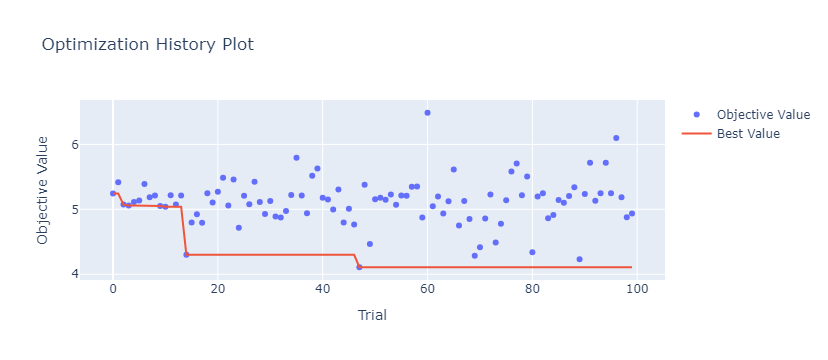

In [29]:
# 結果のプロット (オプション)
optuna.visualization.plot_optimization_history(study_ann).show()

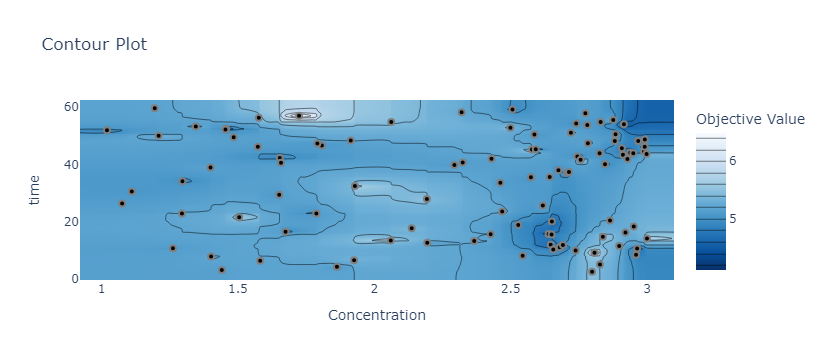

In [30]:
# 結果のプロット (オプション)
optuna.visualization.plot_contour(study_ann).show()